# Self-Driving Car 

## Project Goal: Train a Deep Neural Network to steer a simulated car using only images of what the car sees on the road as an input.

All the main code here is nicely formatted and runnable in [model.py](/model.py). This notebook is just to visualize the data and walkthrought the entire process with code explanations..

## 1. Setup

Some basic setup for the rest of the project.

### Imports

In [1]:
#OpenCV is an open-source computer vision library that supports image processing, video analysis, and machine learning tasks.
!pip install opencv-python


In [2]:
!pip install numpy==1.24

In [3]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals

import argparse
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.misc
import utils

from IPython.display import display
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, Dense, Dropout, Flatten, Lambda, Conv2D
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from PIL import Image
from sklearn.model_selection import train_test_split

%matplotlib inline

### Constants

In [4]:
kSEED = 5 # Sets the random seed
SIDE_STEERING_CONSTANT = 0.25 
NUM_BINS = 23 # histogram creation
NB_EPOCH = 15 
LR = 1e-3

## 2. Data Analysis

In this section we analayze all the training data before we preprocess it and feed it into the model to train on. The data here is created by using the simulator train option. 

### Load data

In [5]:
# Location of the training data from Udacity.
file_name = 'driving_log.csv'
columns = [
    'Center Image',
    'Left Image',
    'Right Image',
    'Steering Angle',
    'Throttle',
    'Break',
    'Speed']

data = pd.read_csv(file_name, names=columns, header=0)
data[columns[:3]] = data[columns[:3]].astype(str)
data[columns[3:]] = data[columns[3:]].astype(float)
angles = data[columns[3]]

### What the data looks like

In [6]:
display(data.head())

,Center Image,Left Image,Right Image,Steering Angle,Throttle,Break,Speed
0,C:\Users\helen\udacity\simulator-windows-32\IM...,C:\Users\helen\udacity\simulator-windows-32\I...,C:\Users\helen\udacity\simulator-windows-32\I...,0.0,0.0,0.0,0.000079
1,C:\Users\helen\udacity\simulator-windows-32\IM...,C:\Users\helen\udacity\simulator-windows-32\I...,C:\Users\helen\udacity\simulator-windows-32\I...,0.0,0.0,0.0,0.000078
2,C:\Users\helen\udacity\simulator-windows-32\IM...,C:\Users\helen\udacity\simulator-windows-32\I...,C:\Users\helen\udacity\simulator-windows-32\I...,0.0,0.0,0.0,0.000080
3,C:\Users\helen\udacity\simulator-windows-32\IM...,C:\Users\helen\udacity\simulator-windows-32\I...,C:\Users\helen\udacity\simulator-windows-32\I...,0.0,0.0,0.0,0.000078
4,C:\Users\helen\udacity\simulator-windows-32\IM...,C:\Users\helen\udacity\simulator-windows-32\I...,C:\Users\helen\udacity\simulator-windows-32\I...,0.0,0.0,0.0,0.000079


### Data Statistics

It's always important to understand basic statistics about the data you will train on to avoid any bias. With pandas, it's super easy to analyze the data. Let's analyze the float values and also plot the steering angles to identify any potential biases.

In [7]:
display(data.describe())

,Steering Angle,Throttle,Break,Speed
count,301.000000,301.000000,301.0,3.010000e+02
mean,-0.033325,0.109837,0.0,2.340637e+00
std,0.161194,0.301089,0.0,6.600782e+00
min,-1.000000,0.000000,0.0,5.078670e-07
25%,0.000000,0.000000,0.0,7.802801e-05
50%,0.000000,0.000000,0.0,7.839024e-05
75%,0.000000,0.000000,0.0,7.968112e-05
max,0.000000,1.000000,0.0,3.019738e+01


Lets plot a histogram of the steering angles to get a better idea of how many examples we have for each angle.

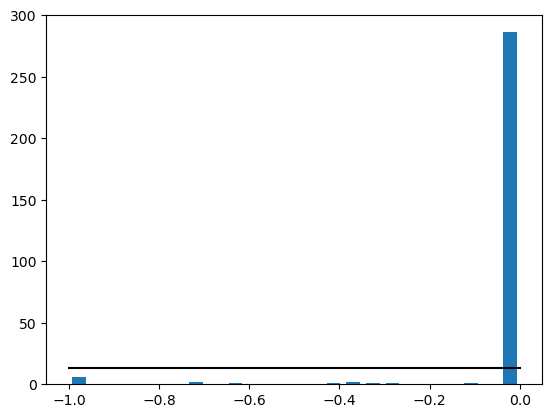

In [8]:
num_bins = 23
avg_samples_per_bin = len(data['Steering Angle'])/num_bins
hist, bins = np.histogram(data['Steering Angle'], num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

### Interesting Observations

1. Steering angle varies between -1.0 and 1.0 but its almost always 0 (driving straight). This is not good as then our model would be biased to driving straight.
2. The car was driven at it's medarate speed most of the time.
3. The throttle was barely adjusted while driving and same with the breaking which was rarely applied.
4. Steering data is biased towards turning left.

### Data pre-processing

Let's fix our training data to get rid of our bias to driving straight and turning left. We can use some statistical probability techniques here to make the data look more even for each example. The following code computes probabilities for each bin and drops random samples (higher probability of being dropped if closer to 0).

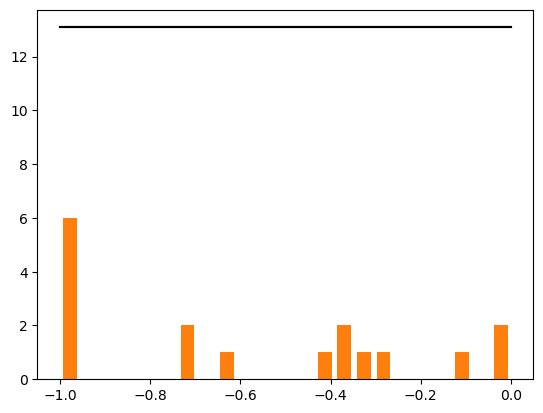

In [12]:
# Down-sampling ensures a more balanced dataset
keep_probs = []
target = avg_samples_per_bin * .3
for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/target))
        
remove_list = []
for i in range(len(data['Steering Angle'])):
    for j in range(num_bins):
        if data['Steering Angle'].iloc[i] > bins[j] and data['Steering Angle'].iloc[i] <= bins[j+1]:
            # delete from X and y with probability 1 - keep_probs[j]
            if np.random.rand() > keep_probs[j]:
                remove_list.append(i)
data.drop(data.index[remove_list], inplace=True)

# print histogram again to show more even distribution of steering angles
hist, bins = np.histogram(data['Steering Angle'], num_bins)
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(data['Steering Angle']), np.max(data['Steering Angle'])), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
keep_probs = []
target = avg_samples_per_bin * .3
for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/target))
        
remove_list = []
for i in range(len(data['Steering Angle'])):
    for j in range(num_bins):
        if data['Steering Angle'].iloc[i] > bins[j] and data['Steering Angle'].iloc[i] <= bins[j+1]:
            # delete from X and y with probability 1 - keep_probs[j]
            if np.random.rand() > keep_probs[j]:
                remove_list.append(i)
data.drop(data.index[remove_list], inplace=True)

# print histogram again to show more even distribution of steering angles
hist, bins = np.histogram(data['Steering Angle'], num_bins)
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(data['Steering Angle']), np.max(data['Steering Angle'])), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

### Sample Images of training data.

These are three samples from the same time momement in the simulation. Notice how the edges and lanes are more visible in the right and left cameras. We will train our model using all three cameras but our final model for prediction will only use our center camera for simplicity. We also need to modify the steering angle by adding and subtracting a small constant for the left and right images to handle the shift.

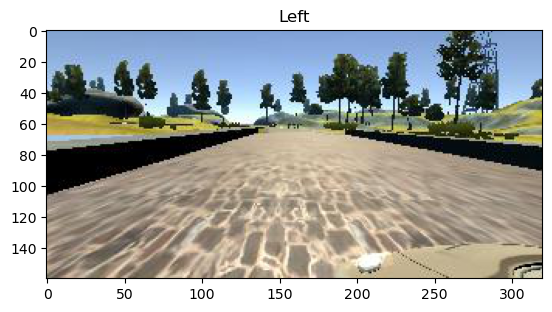

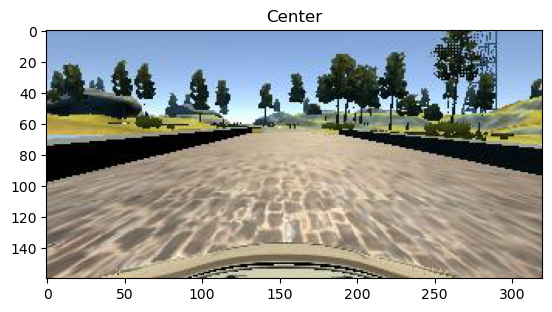

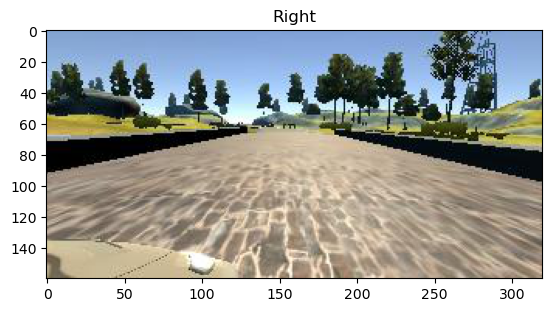

In [13]:
left_image = Image.open('images/left.jpg')
_ = plt.imshow(left_image)
plt.title('Left')
plt.show()

center_image = Image.open('images/center.jpg')
_ = plt.imshow(center_image)
plt.title('Center')
plt.show()

right_image = Image.open('images/right.jpg')
_ = plt.imshow(right_image)
plt.title('Right')
plt.show()

## Train-Test split

Here we use 85% of the data to train and 15% to validate our model. This is a common practice when training machine learning models.

In [14]:
images = data[columns[:3]]
angles = data[columns[3]]

X_train, X_val, y_train, y_val = train_test_split(images, angles, test_size=0.15, random_state=kSEED)

## 3. Data Augmentation



### Helper augmentation image functions

We have four helper image functions detailed below:

1. load_image: Loads an image from disk.
2. flip_image: Loads an image from disk and flips it to give an example of steering in the opposite direction.
3. tint_image: Loads an image from disk and tints it to make it look like the car is driving during a different time of day (helps deal with driving at night).
4. jitter_image: Open image from disk and jitters it and modifies new angle. This is to simulate being on a different position on the track at that time.
5. resize_crop: Crops the image to focus only on road and then resizes it.

In [15]:
from PIL import Image
from PIL import Image

def resize_crop(img):
    """
    Crops the image to focus only on road and then resizes it.

    :param img: Image to crop and resize.

    :return: A cropped image.
    """
    img = np.array(img, np.float32)
    img = img[35:135, :]  # Crop the image
    img = Image.fromarray(np.uint8(img))  # Convert to PIL image
    img = img.resize((200, 66), Image.Resampling.LANCZOS)  # Resize using LANCZOS filter
    return np.array(img, np.float32)




def jitter_image(path, steering):
    """
    Open image from disk and jitters it and modifies new angle.

    :param path: Path of image.
    :param steering: Steering angle corresponding to image.

    :return: Jittered image and new steering angle.
    """
    img = cv2.imread(path.strip())
    rows, cols, _ = img.shape
    transRange = 100
    numPixels = 10
    valPixels = 0.4
    transX = transRange * np.random.uniform() - transRange / 2
    transY = numPixels * np.random.uniform() - numPixels / 2
    transMat = np.float32([[1, 0, transX], [0, 1, transY]])
    steering = steering + transX / transRange * 2 * valPixels
    img = cv2.warpAffine(img, transMat, (cols, rows))
    return resize_crop(img), steering


def flip_image(path):
    """
    Flips the image.

    :param path: Path of image to flip.

    :return: A flipped image.
    """
    img = Image.open(path.strip())
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
    return resize_crop(img)


def tint_image(path):
    """
    Applies random tint to image to simulate night time.

    :param path: Path of image to flip.

    :return: A tinted image.
    """
    img = cv2.imread(path.strip())
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img = np.array(img, dtype=np.float64)
    random_bright = .5 + np.random.uniform()
    img[:, :, 2] = img[:, :, 2] * random_bright
    img[:, :, 2][img[:, :, 2] > 255] = 255
    img = np.array(img, dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return resize_crop(img)


def load_image(path):
    """
    Loads an image give path.

    :param path: Path of image to flip.

    :return: An image.
    """
    img = Image.open(path.strip())
    return resize_crop(img)

### Visualize preprocessing.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


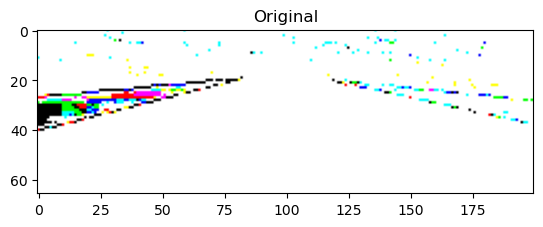

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


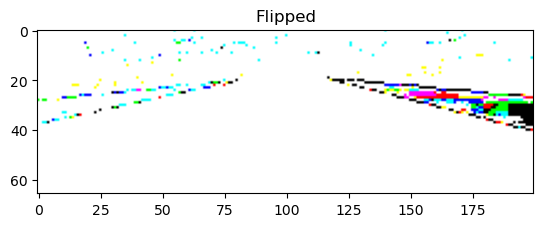

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


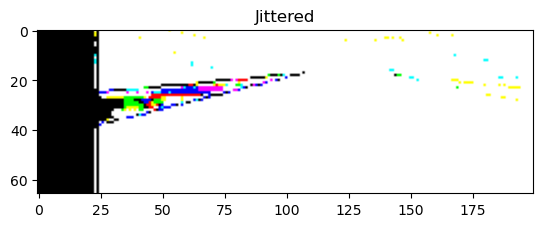

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


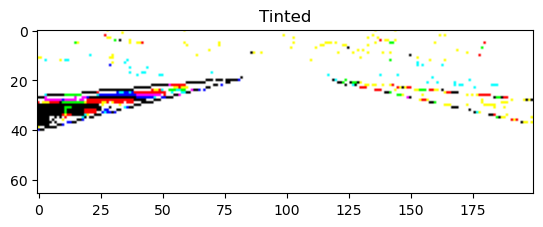

In [16]:
path = 'images/center.jpg'

original_image = load_image(path)
_ = plt.imshow(original_image)
plt.title('Original')
plt.show()

flipped_image = flip_image(path)
_ = plt.imshow(flipped_image)
plt.title('Flipped')
plt.show()

jittered_image, steering = jitter_image(path, 0.0)
_ = plt.imshow(jittered_image)
plt.title('Jittered')
plt.show()

tinted_image = tint_image(path)
_ = plt.imshow(tinted_image)
plt.title('Tinted')
plt.show()

## 4. Generate Training Data

We can create a batch generator which we will take all the data we currently have from the CSV file, augment it and pass it into our model. The goal of the batch generator is to create a data input such that for every image we have the corresponding speed. It also allows us to apply all the preproccessing we did to each image and keep it as our data.

The augment_data parameter tells us if we want to use our data augmentation methods from above on each of our training iamges. This is a good idea at training time because it gives us 5 additional examples (left, right, flipped, tinted, jittered) to supplement the center image and hence gives us more training examples. During validation time however, since we don't augument live data we avoid this and set the parameter to false.

The batch_generator which is a Keras functionality, allows us to create a custom generator that passes in batches of 64 training examples at a time for the model to train on. We can customize what data is passed in.

It would be a good idea here to create more preprocessing methods that do other things such as randomly shear an image, horizontally crop some images to limit data, darken images, etc. to create a better dataset. For the sake of this hacktorial we will limit it to only cropping and flipping.

In [17]:
import numpy as np
import pandas as pd

def batch_generator(images, angles, augment_data=True, batch_size=64):
    """
    Keras Batch Generator to create a generator of training examples for the model.

    :param images: DataFrame containing image paths for 'Center Image', 'Left Image', 'Right Image'.
    :param angles: Series containing steering angles for each image.
    :param batch_size: Batch size for each training run.
    :param augment_data: Whether to augment data.

    :return: A generator yielding batches of (inputs, labels).
    """
    while True:  # Infinite loop for generator
        indices = np.random.permutation(len(images))
        for offset in range(0, len(images), batch_size):
            batch_indices = indices[offset:offset + batch_size]

            batch_images = []
            batch_angles = []

            for i in batch_indices:
                # Load center image and steering angle
                center_path = images.iloc[i]['Center Image']
                angle = angles.iloc[i]

                center_image = load_image(center_path)  # Implement load_image correctly
                batch_images.append(center_image)
                batch_angles.append(angle)

                if augment_data:
                    # Augmented data
                    flipped_image = flip_image(center_path)
                    batch_images.append(flipped_image)
                    batch_angles.append(-angle)  # Reverse angle for flipped image

            # Ensure output as numpy arrays
            yield np.array(batch_images), np.array(batch_angles)


## 5. Building the Model

Model is based on NVIDIA's "End to End Learning for Self-Driving Cars" paper [End-to-End Deep Learning for Self-Driving Cars](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf).

The differences between their model and ours is that we add a Maxpooling layer after every Convolutional layer to speed up computation and also have more fully-connected (dense) layers.

The model will take in an image (either from the left, center, or right camera) and output a single number between -1 and 1 representing the steering angle. We used Keras to implement the model. Keras is a deep learning library that runs on Tensorflow or Theano and is best for fast prototyping. For more intensive deep learning tasks, PyTorch or TensorFlow may be a better option.


In [26]:
model = Sequential()
# Lambda layer normalizes pixel values between 0 and 1
model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(66, 200, 3)))
# Convolutional layer (1)
model.add(Conv2D(24, (5,5), padding='same', activation='relu', strides=(2,2)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))
# Convolutional layer (2)
model.add(Conv2D(36, (5,5), padding='same', activation='relu', strides=(2,2)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))
# Convolutional layer (3)
model.add(Conv2D(48, (5,5), padding='same', activation='relu', strides=(2,2)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))
# Convolutional layer (4)
model.add(Conv2D(64, (3,3), padding='same', activation='relu', strides=(1,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))
# Convolutional layer (5)
model.add(Conv2D(64, (3,3), padding='same', activation='relu', strides=(1,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))
# Flatten Layer
model.add(Flatten())
# Dense Layer (1)
model.add(Dense(356, activation='relu'))
# Dense layer (2)
model.add(Dense(128, activation='relu'))
# Dense layer (3)
model.add(Dense(52, activation='relu'))
# Dense layer (4)
model.add(Dense(8, activation='relu'))
# Dense layer (5)
model.add(Dense(1))

# Compile model
from keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=LR), loss='mse')


#### Model Summary

In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)                    │ (None, 66, 200, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 33, 100, 24)         │           1,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 99, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 50, 36)          │          21,636 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 15, 49, 36)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 8, 25, 48)           │          43,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 7, 24, 48)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 7, 24, 64)           │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 6, 23, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 6, 23, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 5, 22, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 7040)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 356)                 │       2,506,596 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          45,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 52)                  │           6,708 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 8)                   │             424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,690,781 (10.26 MB)

 Trainable params: 2,690,781 (10.26 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Training the Model

Let's create the generators for our training and validation examples. Remember that for our validation examples, we don't augment the data.

In [28]:
generator_train = batch_generator(X_train, y_train, augment_data=True)
generator_val = batch_generator(X_val, y_val, augment_data=False)

Fit the model to the data we created from our batch generator. Here steps per epoch is the number of examples we have which is 6 times the number of training examples. We get the number six from the original 3 left, right, center examples + the three augmented examples (flipped, tinted, jittered). For the steps in validation however since we only use center images its simply how many examples we have. We train our model for 15 epochs.

In [29]:
inputs, labels = next(generator_train)
print(f"Inputs shape: {inputs.shape}")
print(f"Labels shape: {labels.shape}")

Inputs shape: (28, 66, 200, 3)
Labels shape: (28,)


In [30]:
history = model.fit(
    generator_train,
    steps_per_epoch=6 * len(X_train),
    epochs=NB_EPOCH,
    validation_data=generator_val,
    validation_steps=len(X_val),
    verbose=1)

Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - loss: 0.2202 - val_loss: 0.0790
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - loss: 1.0149e-05 - val_loss: 0.0835
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - loss: 3.4903e-05 - val_loss: 0.0806
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - loss: 1.0965e-04 - val_loss: 0.0832
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - loss: 1.6573e-08 - val_loss: 0.0832
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - loss: 3.0473e-12 - val_loss: 0.0832
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - loss: 1.4174e-13 - val_loss: 0.0832
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - loss: 1.2464e-13 - val_loss: 0.0832
Epoch 9/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - loss: 0.0098 - val_loss: 0.2201
Epoch 10/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - loss: 0.0412 - val_loss: 0.1088
Epoch 11/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - loss: 3.7692e-05 - val_loss: 0.1122
Epoch 12/

We can save model for later use.

In [31]:
# save_weights
model.save_weights('model.weights.h5')

# save_structure
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)



Visualize training loss on training and validation.

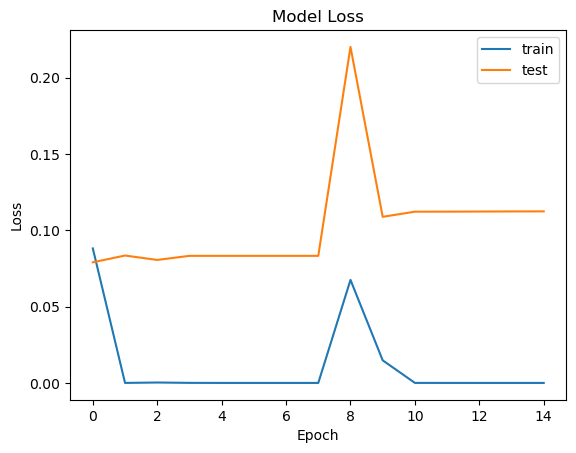

In [32]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## 7. Testing the model on the simulation

Run this following command in the directory after opening up the simulator and selecting the autonomous mode option.

`python drive.py model.json`

If you cave the model's weights and structures together in .keras file. Then you can run:

`python drive.py model.keras`